In [1]:
'''
Created on 06 lug 2017

@author: mantica

https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb
https://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/#turbofan

Binary classification: Predict if an asset will fail within certain time frame (e.g. cycles)

'''

import keras
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from __future__ import print_function
import tensorflow as tf

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import TensorBoard
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split
from keras import backend as K


# define path to save model
model_path = '../../Output/binary_model.h5'



C:\Users\nikit.patel.PRIYASOFT\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('../../Dataset/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('../../Dataset/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('../../Dataset/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [3]:
##################################
# Data Preprocessing
##################################

#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2


In [4]:
# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)


In [5]:
######
# TEST
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [6]:
# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2


In [7]:
##################################
# LSTM
##################################

# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        

In [8]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)


In [9]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [10]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target. 
    return data_matrix[seq_length:num_elements, :]


In [11]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [12]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

In [13]:
nb_features,nb_out

(25, 1)

In [14]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42) # Want a balanced split for all the classes
for train_index, test_index in sss.split(seq_array, label_array):
    print("Using {} for training and {} for validation".format(len(train_index), len(test_index)))
    x_train, x_valid = seq_array[train_index], seq_array[test_index]
    y_train, y_valid = label_array[train_index], label_array[test_index]

Using 12504 for training and 3127 for validation


In [15]:
def batch_generator(X, y, batch_size=16):
    '''
    Return a random image from X, y
    '''
    
    while True:
        # choose batch_size random images / labels from the data
        idx = np.random.randint(0, X.shape[0], batch_size)
        #print(idx)
        im = X[idx]
        label = y[idx]

        yield im, label
        


In [16]:
train_gen = batch_generator(x_train, y_train, batch_size=32)
valid_gen = batch_generator(x_valid, y_valid, batch_size=32)

In [17]:
# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
# fit the network
# steps_per_epoch=50,validation_steps=10
# history = model.fit_generator(x_train, y_train, epochs=10, validation_split=0.33, verbose=1,batch_size=200,
#           callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
#                        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
#           )

# # list all data in history
# print(history.history.keys())

In [19]:
history = model.fit_generator(
    generator=train_gen,
    epochs=10,
    steps_per_epoch=x_train.shape[0] // 32,
    validation_data=valid_gen,
    validation_steps=x_valid.shape[0] // 32,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
           )

print(history.history.keys())

Epoch 1/10
390/390 [==============================] - 23s 59ms/step - loss: 0.1582 - acc: 0.9355 - val_loss: 0.1299 - val_acc: 0.9465
Epoch 2/10
390/390 [==============================] - 21s 54ms/step - loss: 0.1044 - acc: 0.9573 - val_loss: 0.0711 - val_acc: 0.9684
Epoch 3/10
390/390 [==============================] - 24s 62ms/step - loss: 0.0793 - acc: 0.9677 - val_loss: 0.1041 - val_acc: 0.9504
Epoch 4/10
390/390 [==============================] - 27s 70ms/step - loss: 0.0690 - acc: 0.9720 - val_loss: 0.0498 - val_acc: 0.9787
Epoch 5/10
390/390 [==============================] - 27s 70ms/step - loss: 0.0610 - acc: 0.9732 - val_loss: 0.0574 - val_acc: 0.9784
Epoch 6/10
390/390 [==============================] - 23s 60ms/step - loss: 0.0676 - acc: 0.9725 - val_loss: 0.0458 - val_acc: 0.9765
Epoch 7/10
390/390 [==============================] - 24s 61ms/step - loss: 0.0550 - acc: 0.9774 - val_loss: 0.0469 - val_acc: 0.9774
Epoch 8/10
390/390 [==============================] - 26s 67ms

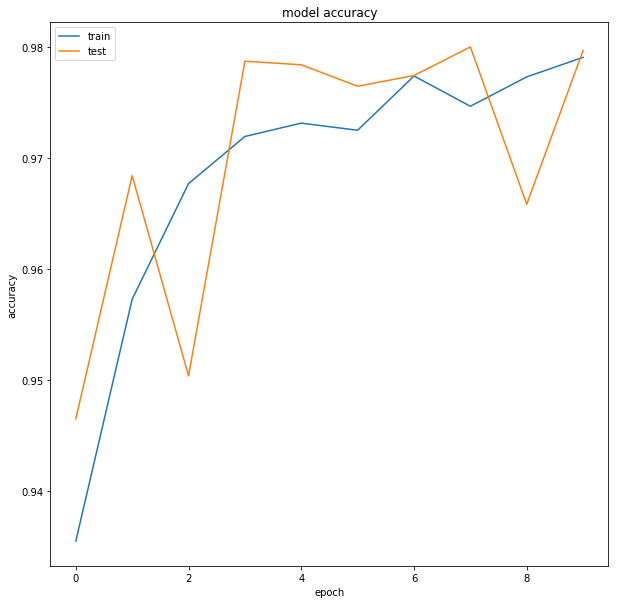

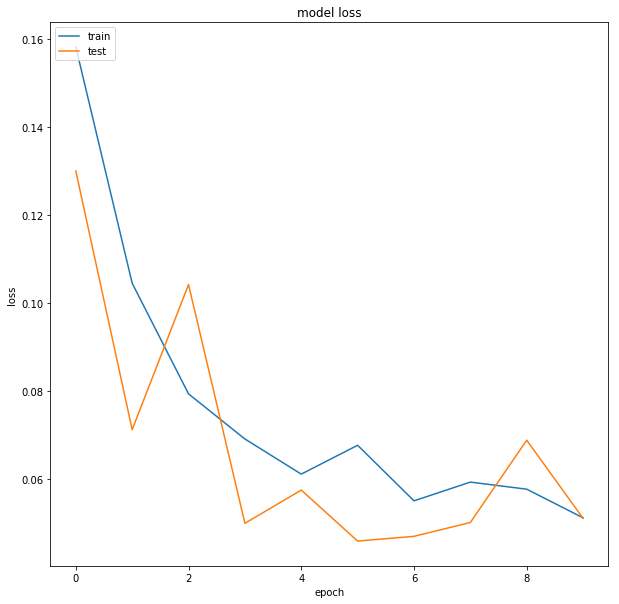

In [20]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("../../Output/model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("../../Output/model_loss.png")

In [21]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('../../Output/binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

15631/15631 [==============================] - 6s 406us/step
Accurracy: 0.9774806559425223
15631/15631 [==============================] - 6s 409us/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12381   150]
 [  202  2898]]


In [22]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)


precision =  0.9507874015748031 
 recall =  0.9348387096774193


In [23]:
##################################
# EVALUATE ON TEST DATA
##################################

# We pick the last sequence for each id in the test data

seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
print(seq_array_test_last)
print(seq_array_test_last.shape)

seq_array_test_last
[[[0.3505747  0.8333333  0.         ... 0.         0.4728682  0.45457056]
  [0.39655173 0.5833333  0.         ... 0.         0.6511628  0.5608948 ]
  [0.5114943  0.25       0.         ... 0.         0.6356589  0.4975145 ]
  ...
  [0.43678162 0.75       0.         ... 0.         0.41860464 0.4710025 ]
  [0.5804598  0.6666667  0.         ... 0.         0.3255814  0.45954156]
  [0.40804598 0.8333333  0.         ... 0.         0.6124031  0.52444077]]

 [[0.55172414 0.25       0.         ... 0.         0.5503876  0.6974593 ]
  [0.39655173 0.5833333  0.         ... 0.         0.37209302 0.59748685]
  [0.5344828  0.16666667 0.         ... 0.         0.51937985 0.602596  ]
  ...
  [0.43103448 0.33333334 0.         ... 0.         0.56589144 0.49461475]
  [0.33908045 0.25       0.         ... 0.         0.4108527  0.5223695 ]
  [0.5689655  0.8333333  0.         ... 0.         0.34108528 0.5024855 ]]

 [[0.7356322  0.25       0.         ... 0.         0.53488374 0.6023198 ]
  

In [24]:
# Similarly, we pick the labels

#print("y_mask")
# serve per prendere solo le label delle sequenze che sono almeno lunghe 50
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
print("y_mask")
print(y_mask)
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print("label_array_test_last")
print(label_array_test_last)

y_mask
[False, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
(93, 1)
label_array_test_last
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 

In [25]:

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = estimator.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('../../Output/binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Accurracy: 0.9677419425338827
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[66  2]
 [ 1 24]]
Precision:  0.9230769230769231 
 Recall:  0.96 
 F1-score: 0.9411764705882353


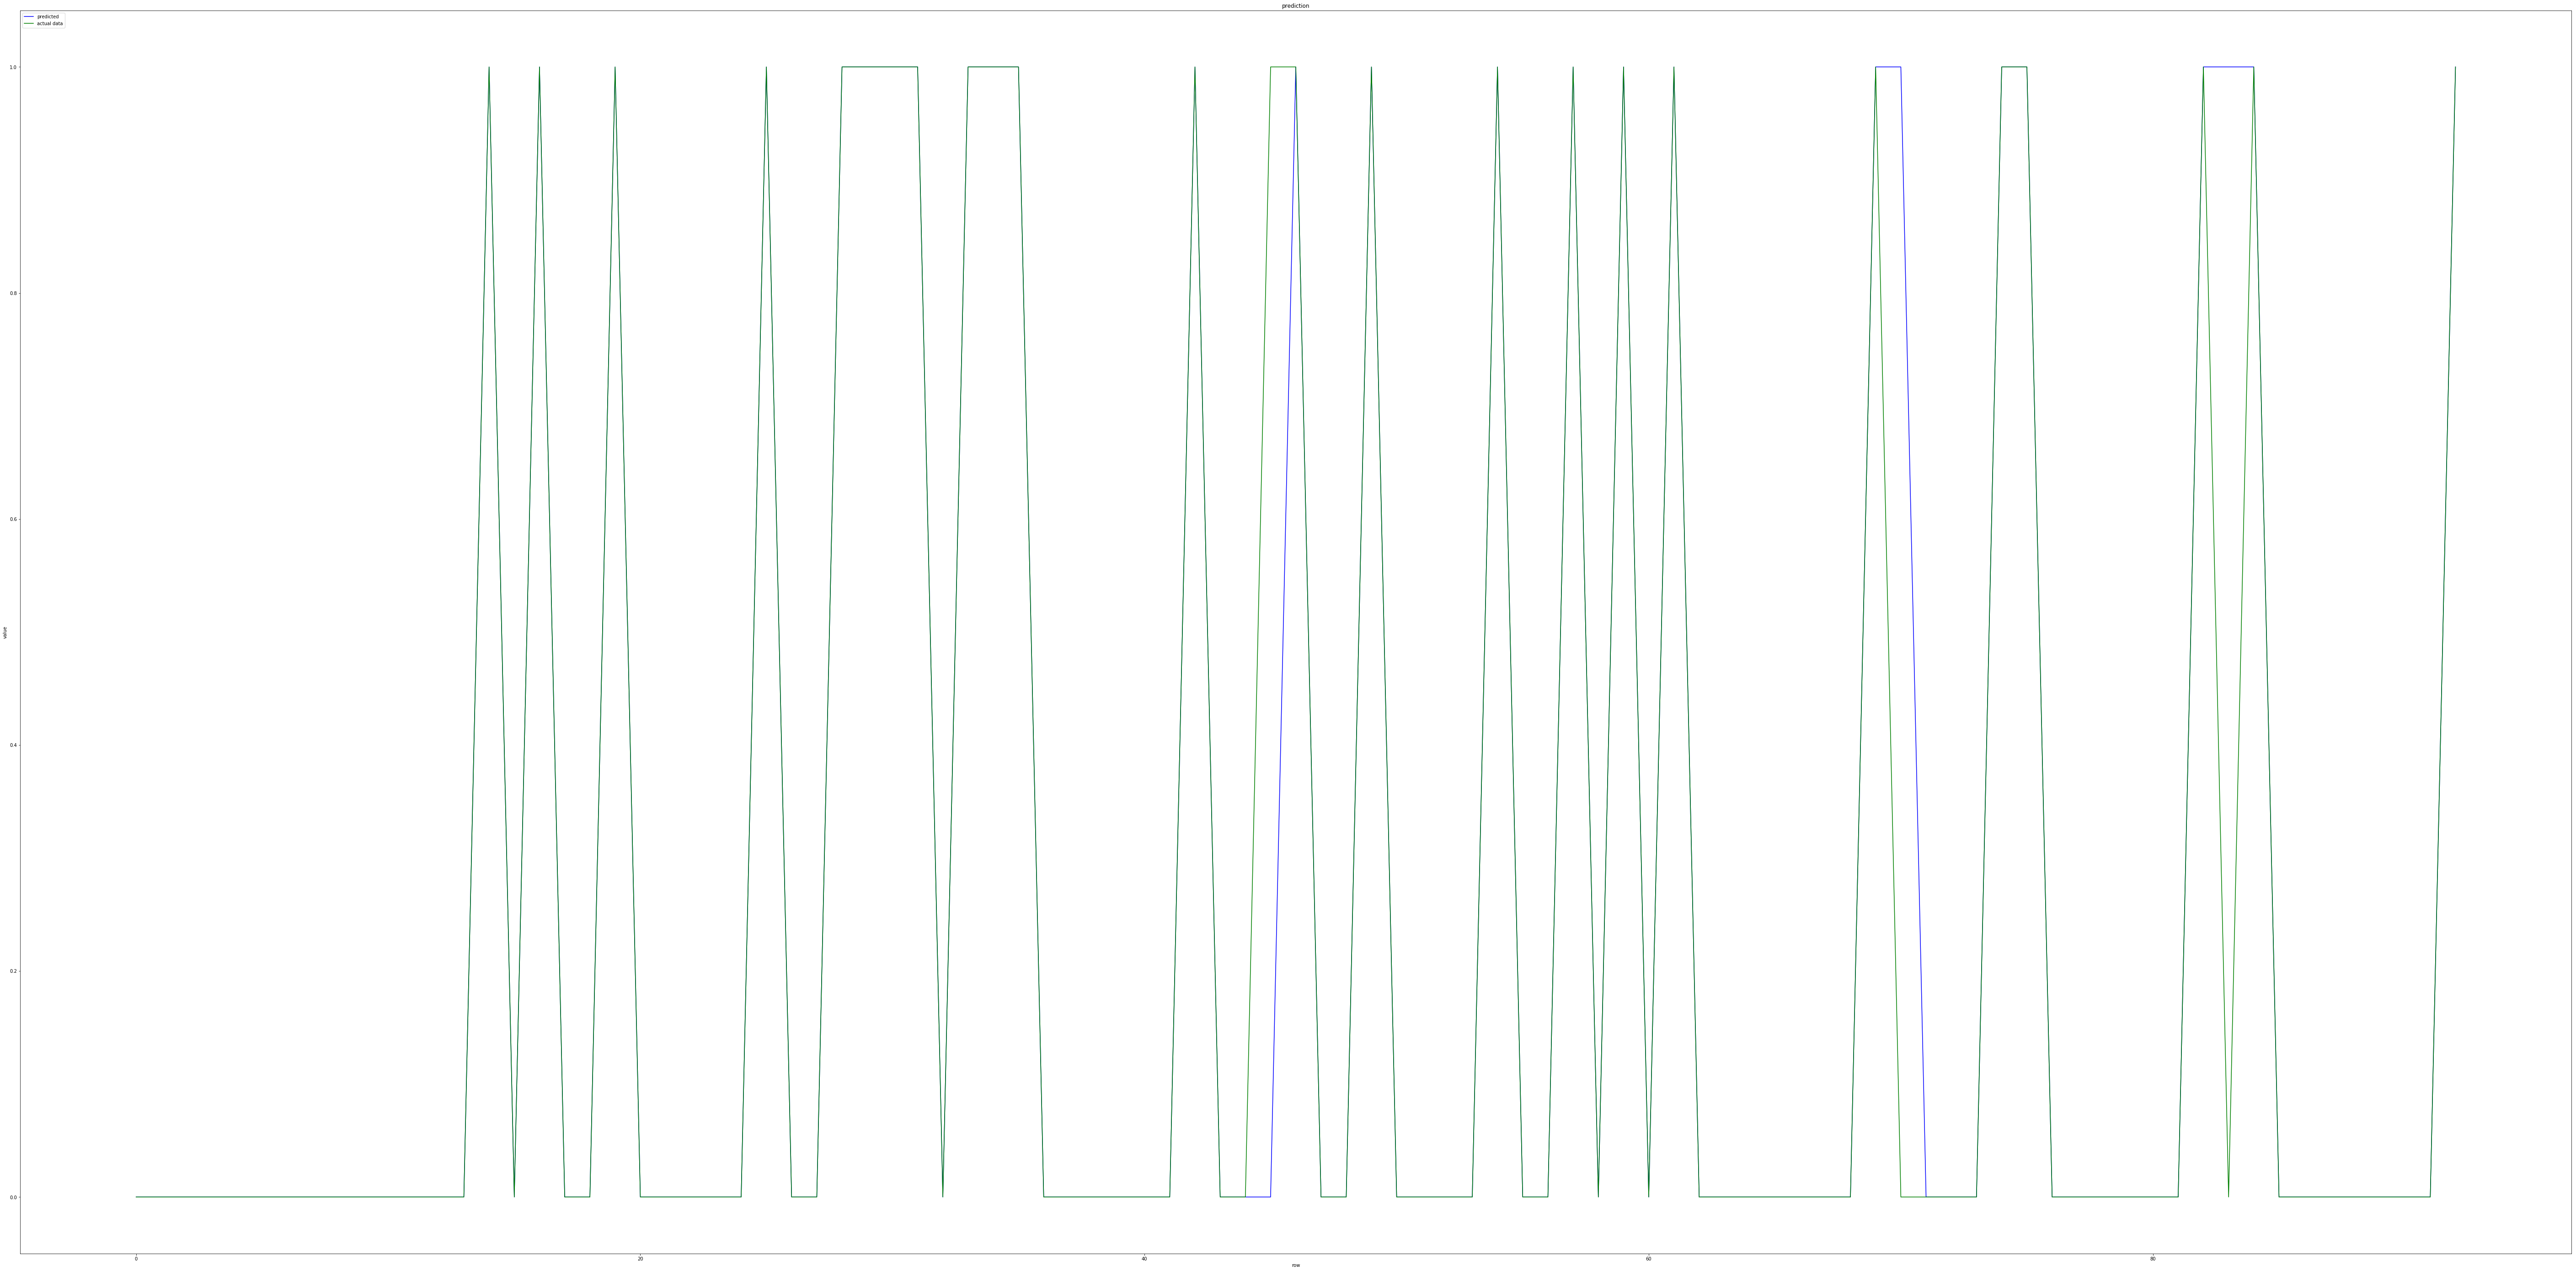

In [26]:
# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(100, 50))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("../../Output/model_verify.png")

In [27]:
# Epoch 20/20
# 1000
# 10472/10472 [==============================] - 10s 990us/step - loss: 0.0535 - acc: 0.9789 - val_loss: 0.0440 - val_acc: 0.9824
# 100
# 10472/10472 [==============================] - 16s 2ms/step - loss: 0.0422 - acc: 0.9816 - val_loss: 0.0637 - val_acc: 0.9715
# 10
# 10472/10472 [==============================] - 36s 3ms/step - loss: 0.0420 - acc: 0.9827 - val_loss: 0.0460 - val_acc: 0.9808


# Epoch 10/10
# 50/50 [==============================] - 529s 11s/step - loss: 0.0262 - acc: 0.9889 - val_loss: 0.0850 - val_acc: 0.9734